<a href="https://colab.research.google.com/github/ShaelinN/GameOutcomePrediction/blob/master/outlier_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [268]:
import pandas as pd
import os
import numpy as np

In [269]:
from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [270]:
root = "/content/drive/MyDrive/COMP721_Project"

In [271]:
data = os.path.join(root, "Data")

#preprocessing

In [282]:
player_rs_career = pd.read_csv(os.path.join(data, "player_regular_season_career.csv"))
player_rs_career.head()

,ilkid,firstname,lastname,leag,gp,minutes,pts,oreb,dreb,reb,asts,stl,blk,turnover,pf,fga,fgm,fta,ftm,tpa,tpm
0,ABDELAL01,Alaa,Abdelnaby,N,256,3200,1465,283,563,846,85,71,69,247,484,1236,620,321,225,3,0
1,ABDULKA01,Kareem,Abdul-jabbar,N,1560,57446,38387,2975,9394,17440,5660,1160,3189,2527,4657,28307,15837,9304,6712,18,1
2,ABDULMA01,Mahmo,Abdul-rauf,N,586,15633,8553,219,868,1087,2079,487,46,963,1107,7943,3514,1161,1051,1339,474
3,ABDULTA01,Tariq,Abdul-wahad,N,236,4808,1830,275,501,776,266,184,82,309,485,1726,720,529,372,76,18
4,ABDURSH01,Shareef,Abdur-rahim,N,672,24862,13338,1498,3976,5474,1847,718,556,1911,1845,10215,4789,4427,3614,477,146


In [273]:
#  ONLY RUN THIS BLOCK IF YOU WANT TO CONSIDER NBA PLAYERS AND IGNORE ABA

print(player_rs_career.shape)
player_rs_career = player_rs_career.where(player_rs_career["leag"] == "N").dropna()
player_rs_career = player_rs_career.drop("leag", axis=1)
print(player_rs_career.shape)

(3759, 21)
(3250, 20)


##keys: 
the learners will not have access to this part of the data

In [283]:
player_keys = player_rs_career.loc[:,:"lastname"]

In [284]:
player_all_star= pd.read_csv(os.path.join(data, "player_allstar.csv"))
player_all_star.head()
player_all_star["ilkid"] = [i.upper().strip() for i in player_all_star["ilkid"]]

In [285]:
count = player_all_star[["ilkid"]].groupby("ilkid", as_index=False).size()
count.columns = ["ilkid","times_allstar"]

In [286]:
player_keys = pd.merge(player_keys, count,how="left", on="ilkid")
player_keys["times_allstar"] = player_keys["times_allstar"].fillna(0)
player_keys

,ilkid,firstname,lastname,times_allstar
0,ABDELAL01,Alaa,Abdelnaby,0.0
1,ABDULKA01,Kareem,Abdul-jabbar,19.0
2,ABDULMA01,Mahmo,Abdul-rauf,0.0
3,ABDULTA01,Tariq,Abdul-wahad,0.0
4,ABDURSH01,Shareef,Abdur-rahim,1.0
...,...,...,...,...
3754,ZEVENPH01,Phil,Zevenbergen,0.0
3755,ZIDEKGE01,George,Zidek,0.0
3756,ZOETJI01,Jim,Zoet,0.0
3757,ZOPFBI01,Bill,Zopf,0.0


##player "vectors":
this is the data the learners will see (either full or feature-compressed version can be used)

In [287]:
Dn_player_vecs = player_rs_career.loc[:,"gp":]
pca = PCA(n_components=2)
D2_player_vecs = pca.fit_transform(Dn_player_vecs)

#Models

In [288]:
player_summary = player_keys.copy()

OCSVM = svm.OneClassSVM(nu=0.02)
IF = IsolationForest(contamination=0.02)
EE = EllipticEnvelope(contamination=0.02)

working_player_vecs = Dn_player_vecs #change to D2_player_vecs or Dn_player_vecs

In [289]:
working_player_vecs = working_player_vecs.copy()

In [290]:
ee_outliers = EE.fit_predict(working_player_vecs)
if_outliers = IF.fit_predict(working_player_vecs)
ocsvm_outliers = OCSVM.fit_predict(working_player_vecs)

player_summary["EllipticEnvelope_outlier"] = ee_outliers
player_summary["IsolationForest_outlier"] = if_outliers
player_summary["OneClassSVM_outlier"] = ocsvm_outliers

player_summary.head()

/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (65.335774993635468 > 64.576788470945317). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (66.151027557912698 > 66.080298018992792). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (67.450967457883863 > 64.776471361848039). You may want to try with a higher value of support_fraction (current value: 0.505).
  RuntimeWarning,
/usr/local/lib/python3

,ilkid,firstname,lastname,times_allstar,EllipticEnvelope_outlier,IsolationForest_outlier,OneClassSVM_outlier
0,ABDELAL01,Alaa,Abdelnaby,0.0,1,1,1
1,ABDULKA01,Kareem,Abdul-jabbar,19.0,-1,-1,-1
2,ABDULMA01,Mahmo,Abdul-rauf,0.0,1,1,1
3,ABDULTA01,Tariq,Abdul-wahad,0.0,1,1,1
4,ABDURSH01,Shareef,Abdur-rahim,1.0,1,1,1


#Plotting

In [291]:
def plot(detected_outliers):
  # outlier
  C_0 = np.argwhere(detected_outliers==-1)
  C_0 = D2_player_vecs[C_0]   #since in plotting, only work with D2 vectors (2D)
  C_0 = C_0.transpose() 

  #inlier
  C_1 = np.argwhere(detected_outliers==1)
  C_1 = D2_player_vecs[C_1]   #since in plotting, only work with D2 vectors (2D)
  C_1 = C_1.transpose()

  #plt.figure(figsize=(18,10))

  plt.scatter(C_0[0], C_0[1], label='outlier') #outlier
  plt.scatter(C_1[0], C_1[1], label='inlier')
  
  #plt.xlim(-10000,80000)
  #plt.ylim(-15000,15000)
  
  plt.legend()

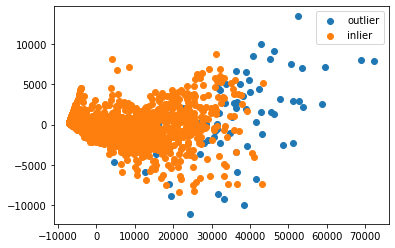

In [292]:
plot(ee_outliers)  # outlier results using elliptic envelope

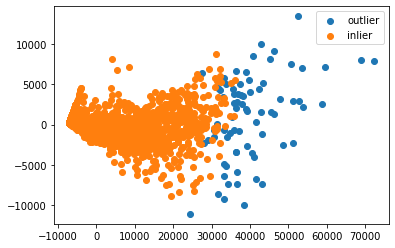

In [293]:
plot(if_outliers) # outlier results using isolation forest

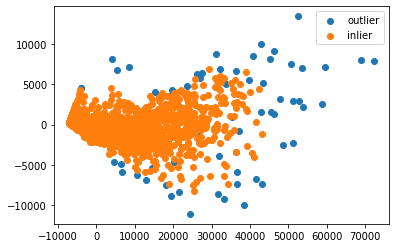

In [294]:
plot(ocsvm_outliers)  # outlier results using one class SVM

#Informal Evaluation

this is not a true evaluation of any kind of metrics. Rather, it checks for correlation between those players rated outlier and those who at some time were in the all-stars.

we use the fact that a player made it into the allstars group as a heuristic to say whether they are infact outstanding

##what proportion of players were in allstars?
P(allstar)


In [295]:
stars = player_summary.where(player_summary["times_allstar"] != 0).dropna()



print("P(allstar) =     ", stars.shape[0]/player_summary.shape[0])


P(allstar) =      0.12476722532588454


##what proportion of players were outliers?
P(outlier)


In [296]:
ee_outliers = player_summary.where(player_summary["EllipticEnvelope_outlier"] == -1).dropna()
if_outliers = player_summary.where(player_summary["IsolationForest_outlier"] == -1).dropna()
ocsvm_outliers = player_summary.where(player_summary["OneClassSVM_outlier"] == -1).dropna()


print("EE: P(outlier) =     ", ee_outliers.shape[0]/player_summary.shape[0])
print("IF: P(outlier) =     ", if_outliers.shape[0]/player_summary.shape[0])
print("OCSVM: P(outlier) =  ", ocsvm_outliers.shape[0]/player_summary.shape[0])


EE: P(outlier) =      0.020218143123171058
IF: P(outlier) =      0.020218143123171058
OCSVM: P(outlier) =   0.018355945730247406


##what proportion of inliers were also in allstars?
P(allstar | not outlier)

In [297]:
ee_inliers = player_summary.where(player_summary["EllipticEnvelope_outlier"] == 1).dropna()
if_inliers = player_summary.where(player_summary["IsolationForest_outlier"] == 1).dropna()
ocsvm_inliers = player_summary.where(player_summary["OneClassSVM_outlier"] == 1).dropna()


ee_stars = ee_inliers.where(ee_inliers["times_allstar"] != 0).dropna()
if_stars = if_inliers.where(if_inliers["times_allstar"] != 0).dropna()
ocsvm_stars = ocsvm_inliers.where(ocsvm_inliers["times_allstar"] != 0).dropna()




print("EE: P(allstar | not outlier) =     ", ee_stars.shape[0]/ee_inliers.shape[0])
print("IF: P(allstar | not outlier) =     ", if_stars.shape[0]/if_inliers.shape[0])
print("OCSVM: P(allstar | not outlier) =  ", ocsvm_stars.shape[0]/ocsvm_inliers.shape[0])




EE: P(allstar | not outlier) =      0.10915014933478143
IF: P(allstar | not outlier) =      0.10779256041270703
OCSVM: P(allstar | not outlier) =   0.11273712737127371


##what proportion of outliers were also in allstars?
P(allstar | outlier)

In [298]:
ee_outliers = player_summary.where(player_summary["EllipticEnvelope_outlier"] == -1).dropna()
if_outliers = player_summary.where(player_summary["IsolationForest_outlier"] == -1).dropna()
ocsvm_outliers = player_summary.where(player_summary["OneClassSVM_outlier"] == -1).dropna()


ee_stars = ee_outliers.where(ee_outliers["times_allstar"] != 0).dropna()
if_stars = if_outliers.where(if_outliers["times_allstar"] != 0).dropna()
ocsvm_stars = ocsvm_outliers.where(ocsvm_outliers["times_allstar"] != 0).dropna()




print("EE: P(allstar | outlier) =     ", ee_stars.shape[0]/ee_outliers.shape[0])
print("IF: P(allstar | outlier) =     ", if_stars.shape[0]/if_outliers.shape[0])
print("OCSVM: P(allstar | outlier) =  ", ocsvm_stars.shape[0]/ocsvm_outliers.shape[0])




EE: P(allstar | outlier) =      0.881578947368421
IF: P(allstar | outlier) =      0.9473684210526315
OCSVM: P(allstar | outlier) =   0.7681159420289855
